## Goals for this Project:
I would to do the following:
* Clean and simplify data in with pandas in a dataframe. 
* Generate general data (season, sport events, etc.) to give insight.
* Give a summary table per brand (transaction counts, markup, total money spent, money per transaction, etc.)
* Layered bar plot of transactions per shoe size. 
* Plot the count of transactions over a map of the US to show what regions have more sneakerheads.
* Regression to predict sneaker sales for the next few months.
* Perform clustering analysis and examine clusters to see if there is any interesting connections.

In [156]:
# import dependencies
import os
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


import gmaps
# Google developer API key
from config import gkey

# Configure gmaps
gmaps.configure(api_key=gkey)

#import regression packages
from sklearn import linear_model

print("Packages Installed...")


Packages Installed...


In [138]:
#set path for excel file 
csv_file_path = os.path.join("data", "StockX-Data-Contest-2019-3.xlsx")

#import raw data from excel file
yeezy_vs_offwhite_df = pd.read_excel(csv_file_path, sheet_name = 'Raw Data')
yeezy_vs_offwhite_df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220,2017-02-11,11.0,Rhode Island


In [139]:
# check value counts to see if the dataframe is square
yeezy_vs_offwhite_df.dropna()
yeezy_vs_offwhite_df.count()

Order Date      99956
Brand           99956
Sneaker Name    99956
Sale Price      99956
Retail Price    99956
Release Date    99956
Shoe Size       99956
Buyer Region    99956
dtype: int64

In [140]:
O# check data type of values
yeezy_vs_offwhite_df.dtypes

Order Date      datetime64[ns]
Brand                   object
Sneaker Name            object
Sale Price             float64
Retail Price             int64
Release Date    datetime64[ns]
Shoe Size              float64
Buyer Region            object
dtype: object

In [144]:
# there is a space before the brands remove it 
yeezy_vs_offwhite_df['Brand'] = yeezy_vs_offwhite_df['Brand'].map(lambda x: x.replace(' ',''))

# add markup (sale price - retail price)
yeezy_vs_offwhite_df['Price Markup'] = yeezy_vs_offwhite_df['Sale Price']-yeezy_vs_offwhite_df['Retail Price']
# perform calculations on data to find time on the market
yeezy_vs_offwhite_df['Days on Market'] = yeezy_vs_offwhite_df['Order Date']-yeezy_vs_offwhite_df['Release Date']


yeezy_vs_offwhite_df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Price Markup,Days on Market
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220,2016-09-24,11.0,California,877.0,342 days
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220,2016-11-23,11.0,California,465.0,282 days
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220,2016-11-23,11.0,California,470.0,282 days
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220,2016-11-23,11.5,Kentucky,855.0,282 days
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220,2017-02-11,11.0,Rhode Island,608.0,202 days


In [113]:
# # data munge
# yeezy_vs_offwhite_df["Sale Price"] = yeezy_vs_offwhite_df["Sale Price"].map("${:,.2f}".format)

# perform calculations on data as a whole (count of transactions, mean markup, )
total_transactions = yeezy_vs_offwhite_df['Order Date'].count()
total_avg_markup = yeezy_vs_offwhite_df['Price Markup'].mean()
total_avg_shoesize = yeezy_vs_offwhite_df['Shoe Size'].mean()

total_summary = pd.DataFrame({'Total Number of Transactions': total_transactions,
                            'Average Markup': [total_avg_markup],
                            'Average Shoe Size of Sneakerhead': [total_avg_shoesize]})
# data munge
total_summary['Average Markup'] = total_summary['Average Markup'].map("${:,.2f}".format)
# round to nearest half size
total_summary['Average Shoe Size of Sneakerhead'] = (total_summary['Average Shoe Size of Sneakerhead']*2).round()/2
total_summary['Average Shoe Size of Sneakerhead'] = total_summary['Average Shoe Size of Sneakerhead'].map("{:,.1f}".format)
total_summary

,Total Number of Transactions,Average Markup,Average Shoe Size of Sneakerhead
0,99956,$238.02,9.5


In [114]:
# perform calculations on data by shoe brand
brand_grouped_df = yeezy_vs_offwhite_df.groupby('Brand')
brand_transactions = brand_grouped_df.count()['Order Date']
brand_average = brand_grouped_df.mean()

brand_summary_df = pd.DataFrame({"Transactions Per Brand": brand_transactions,
                                "Average Retail Price": brand_average['Retail Price'],
                                "Average Sale Price": brand_average['Sale Price'],
                                "Average Markup": brand_average['Price Markup'],
                                "Average Shoe Size": brand_average['Shoe Size']})

# data munge
brand_summary_df['Average Retail Price'] = brand_summary_df['Average Retail Price'].map("${:,.2f}".format)
brand_summary_df['Average Sale Price'] = brand_summary_df['Average Sale Price'].map("${:,.2f}".format)
brand_summary_df['Average Markup'] = brand_summary_df['Average Markup'].map("${:,.2f}".format)
# round to nearest half size
brand_summary_df['Average Shoe Size'] = (brand_summary_df['Average Shoe Size'] * 2).round() / 2
brand_summary_df

,Transactions Per Brand,Average Retail Price,Average Sale Price,Average Markup,Average Shoe Size
Brand,,,,,
Yeezy,72162,$219.87,$360.03,$140.16,9.0
Off-White,27794,$179.38,$671.48,$492.10,9.5


In [150]:
# yeezy_vs_offwhite_df['Brand']=='Yeezy'
yeezy_df = yeezy_vs_offwhite_df.loc[yeezy_vs_offwhite_df['Brand']=='Yeezy']
offwhite_df = yeezy_vs_offwhite_df.loc[yeezy_vs_offwhite_df['Brand']=='Off-White']


,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Price Markup,Days on Market
128,2017-09-07,Off-White,Nike-Air-Max-90-Off-White,1600.0,160,2017-09-09,8.0,California,1440.0,-2 days
129,2017-09-07,Off-White,Nike-Air-Max-90-Off-White,1090.0,160,2017-09-09,11.5,New York,930.0,-2 days
130,2017-09-07,Off-White,Nike-Air-Presto-Off-White,1344.0,160,2017-09-09,10.0,New York,1184.0,-2 days
131,2017-09-07,Off-White,Nike-Air-Presto-Off-White,1325.0,160,2017-09-09,10.0,Massachusetts,1165.0,-2 days
132,2017-09-07,Off-White,Nike-Air-VaporMax-Off-White,1800.0,250,2017-09-09,12.0,Kentucky,1550.0,-2 days


In [157]:
# regr = linear_model.LinearRegression()
# train_x = np.asanyarray(yeezy_days)
# train_y = np.asanyarray(yeezy_price)
# regr.fit (train_x, train_y)
# # The coefficients
# print ('Coefficients: ', regr.coef_)
# print ('Intercept: ',regr.intercept_)

ValueError: Expected 2D array, got 1D array instead:
array=[342. 282. 282. ...  49.  49.  49.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

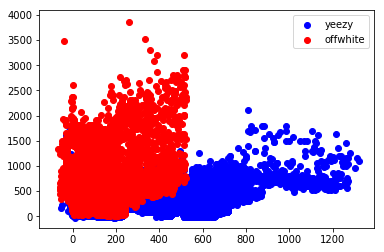

In [158]:
# create a scatter plot of of markup vs 
yeezy_days = yeezy_df['Days on Market'].map(lambda x: x.days).astype(float)
yeezy_price = yeezy_df['Price Markup']
offwhite_days = offwhite_df['Days on Market'].map(lambda x: x.days).astype(float)
offwhite_price = offwhite_df['Price Markup']

fig, ax = plt.subplots()

ax.scatter(yeezy_days, yeezy_price, c='b', label='yeezy')
ax.scatter(offwhite_days, offwhite_price, c='r', label='offwhite')

ax.legend()
ax.set_xlabel('Days on Market')
ax.set
plt.show()

In [41]:
# plot transactions per Region
region_group = yeezy_vs_offwhite_df.groupby('Buyer Region')
region_transactions = region_group.count()['Order Date']
region_average = region_group.mean()

region_summary_df = pd.DataFrame({"Transactions Per Region": region_transactions,
                                "Average Retail Price": region_average['Retail Price'],
                                "Average Sale Price": region_average['Sale Price'],
                                "Average Markup": region_average['Price Markup'],
                                "Average Shoe Size": region_average['Shoe Size']})
# data munge
region_summary_df['Average Retail Price'] = region_summary_df['Average Retail Price'].map("${:,.2f}".format)
region_summary_df['Average Sale Price'] = region_summary_df['Average Sale Price'].map("${:,.2f}".format)
region_summary_df['Average Markup'] = region_summary_df['Average Markup'].map("${:,.2f}".format)
# round to nearest half size
region_summary_df['Average Shoe Size'] = (region_summary_df['Average Shoe Size'] * 2).round() / 2

# grab lat and long of state centers for mapping

# create a plot using folium to plot values over map
# get lat and long data for each neighborhood
lat = []
longs = []
latlongs= []
# create geocode object
geolocator = Nominatim()
# run a loop that grabs lat and long from each state
for state in region_summary_df.index:
#     print(state)

    try: 
        location = geolocator.geocode(state)
        lat.append(location.latitude)
        longs.append(location.longitude)
        latlongs.append([state, location.latitude, location.longitude])
    except Exception as e:
        # geocoders has an issue with Washington State being called by Washington
        latlongs.append([state, 'not found', 'not found'])
        location = geolocator.geocode('USA')
        lat.append(location.latitude)
        longs.append(location.longitude)
        print(state)
        


/Users/albertolszewski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


Washington
Wyoming


In [43]:
# add lat long to dataframe

region_summary_df['Latitude'] = lat
region_summary_df['Longitude'] = longs
# region_summary_df.head()

,Transactions Per Region,Average Retail Price,Average Sale Price,Average Markup,Average Shoe Size,Latitude,Longitude
Buyer Region,,,,,,,
Alabama,457,$211.97,$395.86,$183.89,10.0,33.258882,-86.829534
Alaska,61,$206.89,$435.41,$228.52,9.5,64.445961,-149.680909
Arizona,1398,$208.71,$449.07,$240.36,10.0,34.395342,-111.763276
Arkansas,173,$211.33,$407.86,$196.53,10.0,35.204888,-92.447911
California,19349,$206.82,$478.25,$271.43,9.0,36.701463,-118.755997


In [51]:
# create map of the United States using latitude and longitude values

# Store latitude and longitude in locations
locations = region_summary_df[['Latitude','Longitude']]

# gather transactions and cast as float
transactions = region_summary_df["Transactions Per Region"].astype(float)
transactions

fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=transactions, 
                                 dissipating=False, max_intensity=100,
                                 point_radius=1.5)


# Add layer
fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [75]:
# create a dataframe with shoe size as index containing brand and transactions
# groupby shoe size
shoe_size_group = yeezy_vs_offwhite_df.groupby('Shoe Size')
shoe_size_transactions = shoe_size_group.count()['Order Date']
shoe_size_average = shoe_size_group.mean()

shoe_size_summary_df = pd.DataFrame({"Transactions Per Shoe Size": shoe_size_transactions,
                                "Average Retail Price": shoe_size_average['Retail Price'],
                                "Average Sale Price": shoe_size_average['Sale Price'],
                                "Average Markup": shoe_size_average['Price Markup']
                                })
# data munge
shoe_size_summary_df['Average Retail Price'] = shoe_size_summary_df['Average Retail Price'].map("${:,.2f}".format)
shoe_size_summary_df['Average Sale Price'] = shoe_size_summary_df['Average Sale Price'].map("${:,.2f}".format)
shoe_size_summary_df['Average Markup'] = shoe_size_summary_df['Average Markup'].map("${:,.2f}".format)


# shoe_size_summary_df.head()

,Transactions Per Shoe Size,Average Retail Price,Average Sale Price,Average Markup
Shoe Size,,,,
3.5,4,$242.50,$503.75,$261.25
4.0,2241,$211.87,$382.80,$170.93
4.5,1304,$209.89,$390.94,$181.05
5.0,3577,$213.93,$385.61,$171.68
5.5,2621,$216.10,$373.47,$157.36


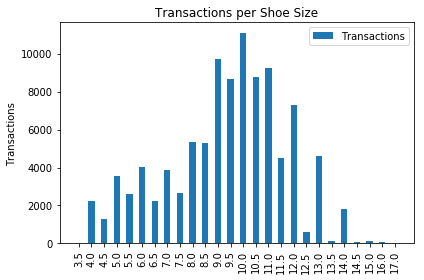

In [71]:
# subplots with three different histograms

# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
# ax1.plot(x, y)
# ax1.set_title('Sharing Y axis')
# ax2.scatter(x, y)
width = 0.5 # the width of the bars
x = np.arange(len(shoe_size_summary_df.index))  # the label locations

fig, ax1= plt.subplots()
rects1 = ax1.bar(x, shoe_size_summary_df['Transactions Per Shoe Size'], width, label='Transactions')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Transactions')
ax1.set_title('Transactions per Shoe Size')
ax1.set_xticks(x)



ax1.set_xticklabels(shoe_size_summary_df.index, rotation = 90)
ax1.legend()


fig.tight_layout()

plt.show()

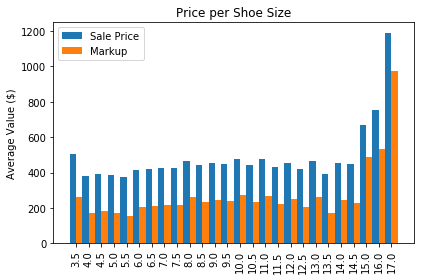

In [88]:
#remove dollar signs and commas to convert to float for plotting
avg_sale = shoe_size_summary_df['Average Sale Price'].map(lambda x: x.lstrip('$').replace(',','')).astype(float)
avg_markup = shoe_size_summary_df['Average Markup'].map(lambda x: x.lstrip('$').replace(',','')).astype(float)

fig, ax2 = plt.subplots()
rects21 = ax2.bar(x - width/2, avg_sale, width, label = 'Sale Price')
rects22 = ax2.bar(x + width/2, avg_markup, width, label = 'Markup')

ax2.set_ylabel('Average Value ($)')
ax2.set_title('Price per Shoe Size')
ax2.set_xticks(x)
# ax2.set_yticks([])

ax2.set_xticklabels(shoe_size_summary_df.index, rotation = 90)
ax2.legend()

fig.tight_layout()

plt.show()